# Notes

# Imports

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
#sys.path.append('../tracking_code/lib/')
#sys.path.append('./lib/')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the tracking data

In [5]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

# Prepare the data used in the plots

Since this is just for visualization, we will use a highly interpolated version, so we don't have visible gaps

In [42]:
sys.path.append('../tracking_code/lib/')
from post_processing import process_1D_timeseries
from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL

In [35]:
# post-process the trajectory
interp_max_gap = 50
interp_polyOrd = 1

smooth_polyOrd = 2
smooth_winSize = 9

In [36]:
expIdx = 2

raw_trajectory = raw_trajectories[expIdx]
winIdx = winner_idxs[expIdx]
losIdx = loser_idxs[expIdx]

numFrames, numFish, numBodyPoints, _ = raw_trajectory.shape

smooth_trajectory = np.ones_like(raw_trajectory)*np.NaN
for fishIdx in range(numFish):
    for bpIdx in range(numBodyPoints):
        for dimIdx in range(3):
            smooth_trajectory[:,fishIdx,bpIdx,dimIdx] = process_1D_timeseries(raw_trajectory[:,fishIdx,bpIdx,dimIdx],
                                                                             interp_max_gap=interp_max_gap,
                                                                             interp_polyOrd=interp_polyOrd,
                                                                             smooth_polyOrd=smooth_polyOrd,
                                                                             smooth_winSize=smooth_winSize)
# put the winner first
if winIdx == 0:
    data = np.copy(smooth_trajectory)
else:
    data = np.copy(smooth_trajectory[:, ::-1, :, :])

In [37]:
data.shape

(501943, 2, 3, 3)

In [43]:
dpp = compute_pec_pec_distance(smooth_trajectory)
tetW, tetL = compute_thetaW_and_thetaL(smooth_trajectory, winIdx, losIdx)

# Compute the average fish size for the experiment

In [47]:

fish_sizes = np.zeros((data.shape[0],2))

for fIdx in range(data.shape[0]):
    
    for fishIdx in range(2):
        
        head_point = data[fIdx, fishIdx, 0, :]
        tail_point = data[fIdx, fishIdx, 2, :]
        fish_size = np.linalg.norm(head_point - tail_point)
        fish_sizes[fIdx, fishIdx] = fish_size

In [48]:
fishs_avg_size = np.nanmean(fish_sizes, axis=0)
fishs_avg_size

array([2.62384623, 2.66879823])

In [49]:
mean_fish_size = np.mean(fishs_avg_size)
mean_fish_size

2.6463222280107814

# Figure 1 B:

False


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
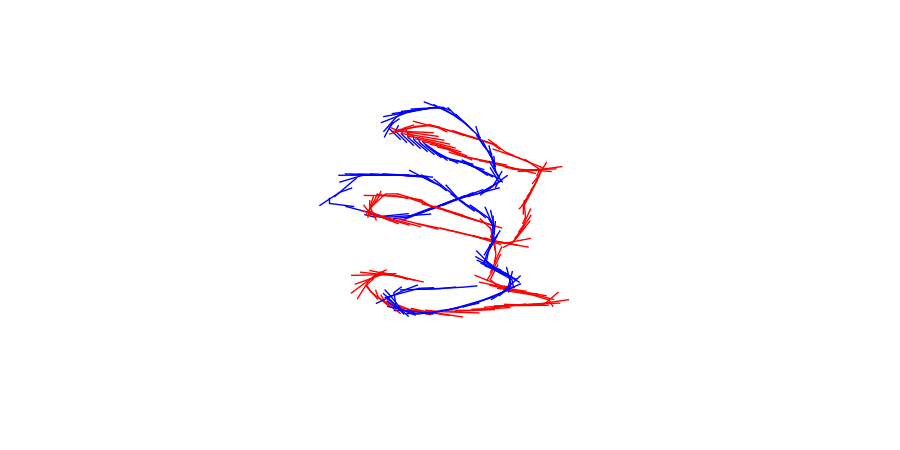

In [39]:
## --- Parameters --- ##


# the starting frame
f0 = 321000

# the gap between frames we will draw
frame_gap = 5

# the total number of frames we want to draw
num_fig_frames = 100

# draw the axes or not
draw_axis = False

imageSavePath = '/home/liam/temp/image_transfer/fig1_B.png'


# ---------------------------------------------------------------------#

# make a list of frame indices
figure_fIdxs = [(f0+i*frame_gap) for i in range(num_fig_frames)]

fE = figure_fIdxs[-1]

# make the alphas for each frame
# in this case, we don't want to draw older frames more transparent,
# so the alpha for each frame results is simply one.
# But you can adjust the alpha values here if you like
alphas = np.ones((num_fig_frames))

# parse the input shapes
_, numFish, numBodyPoints, _ = data.shape
fish_colors = ['red', 'blue']

# --- make the figure -- #

fig = plt.figure(figsize=(9,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')


# Setting the axes properties
ax.set_xlim3d([8, 18])
ax.set_xlabel('X [cm]')

ax.set_ylim3d([13, 27])
ax.set_ylabel('Y [cm]')

ax.set_zlim3d([-1, 32])
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
elevation_angle = 15 #10
azimuthal_angle = 200 #45
ax.view_init(elevation_angle, azimuthal_angle)


# Initialize scatters (list over fish, list over bps)
symbols = ['', '', '']
sizes=18

frame_scatters = []
frame_lines = []
for i,fIdx in enumerate(figure_fIdxs):
    lines = []
    for fishIdx in range(numFish):
        col = fish_colors[fishIdx]
        line = ax.plot(data[fIdx, fishIdx, :, 0], data[fIdx, fishIdx, :, 1], data[fIdx, fishIdx, :, 2], c=col, linewidth=1, alpha=alphas[i])[0]
        lines.append(line)
        
print(draw_axis)

ax.grid(False)
ax.axis(draw_axis)
fig.tight_layout()
fig.savefig(imageSavePath, dpi=400, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
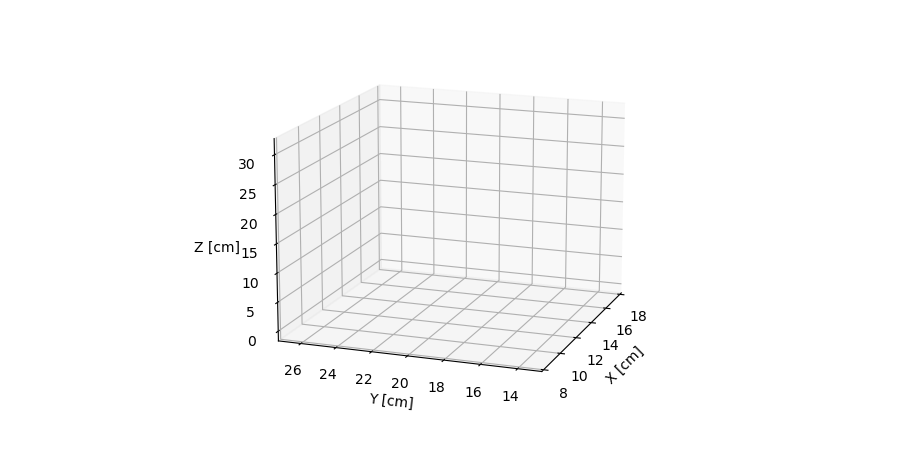

In [40]:
frame_gap = 5

#f0 = 267378
#f0 = 464000
#f0 = 243440
num_fig_frames = 100

# make a list of frame indices
figure_fIdxs = [(f0+i*frame_gap) for i in range(num_fig_frames)]

fE = figure_fIdxs[-1]

# make the alphas, so the first frame has the lowest
# i.e. furtherst back in time is slowest
#alphas = np.linspace(0,1,num=num_fig_frames)
#alphas = np.logspace(-1,0,num=num_fig_frames)
alphas = np.ones((num_fig_frames))

# parse the input shapes
_, numFish, numBodyPoints, _ = data.shape
#fish_colors = ['red', 'blue']
fish_colors = ['red', 'blue']


# --- make the figure -- #


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(9,4.5))


# -- make the 3D panel -- #
ax = fig.add_subplot(1, 1, 1, projection='3d')


# Setting the axes properties
ax.set_xlim3d([8, 18])
ax.set_xlabel('X [cm]')

ax.set_ylim3d([13, 27])
ax.set_ylabel('Y [cm]')

ax.set_zlim3d([-1, 32])
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel('Z [cm]', rotation=0)


# Provide starting angle for the view
elevation_angle = 15 #10
azimuthal_angle = 200 #45
ax.view_init(elevation_angle, azimuthal_angle)


fig.tight_layout()

# Figure 1 C top

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
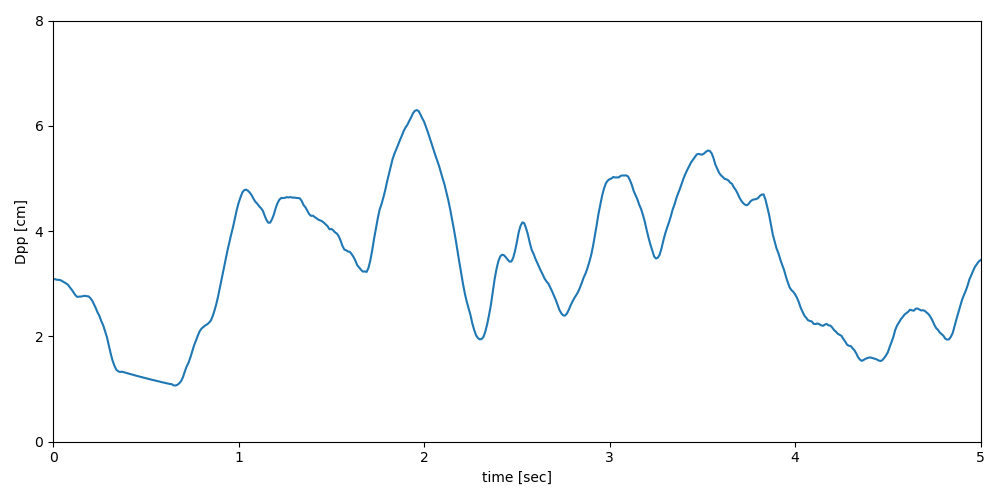

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax = axs
ax.plot(dpp[f0:f0+501])

ax.set_xlim(0,500)
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
ax.set_xlabel('time [sec]')

ax.set_ylim(0, 7)
ax.set_yticks([0,2,4,6,8])
ax.set_yticklabels([0,2,4,6,8])
ax.set_ylabel('Dpp [cm]')

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
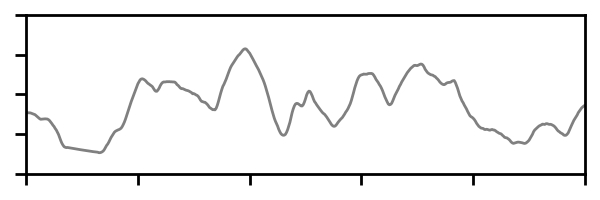

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,2))

ax = axs
ax.plot(dpp[f0:f0+501], linewidth=2, color='grey')

ax.set_xlim(0,500)
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels([])
ax.set_xlabel('')

ax.set_ylim(0, 7)
ax.set_yticks([0,2,4,6,8])
ax.set_yticklabels([])
ax.set_ylabel('')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#ax.legend(fontsize=16, frameon=False, labelspacing=1) #
fig.tight_layout()


#fig.savefig('/home/liam/temp/image_transfer/dpp_plot_v2.png', dpi=300, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
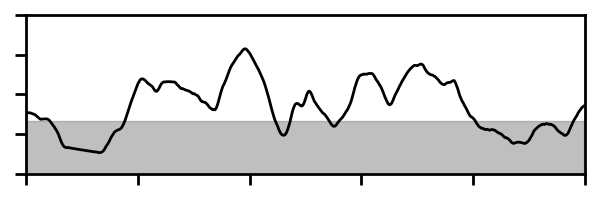

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,2))

ax = axs
ax.plot(dpp[f0:f0+501], linewidth=2, color='black')


# draw the greyed out fish size
ax.fill_between(np.arange(500), 0, mean_fish_size, color='gray', alpha=0.5)


ax.set_xlim(0,500)
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels([])
ax.set_xlabel('')

ax.set_ylim(0, 7)
ax.set_yticks([0,2,4,6,8])
ax.set_yticklabels([])
ax.set_ylabel('')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#ax.legend(fontsize=16, frameon=False, labelspacing=1) #
fig.tight_layout()



fig.savefig('/home/liam/temp/image_transfer/fig1_C_top.png', dpi=300, transparent=True)

# Figure 1 C bottom

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
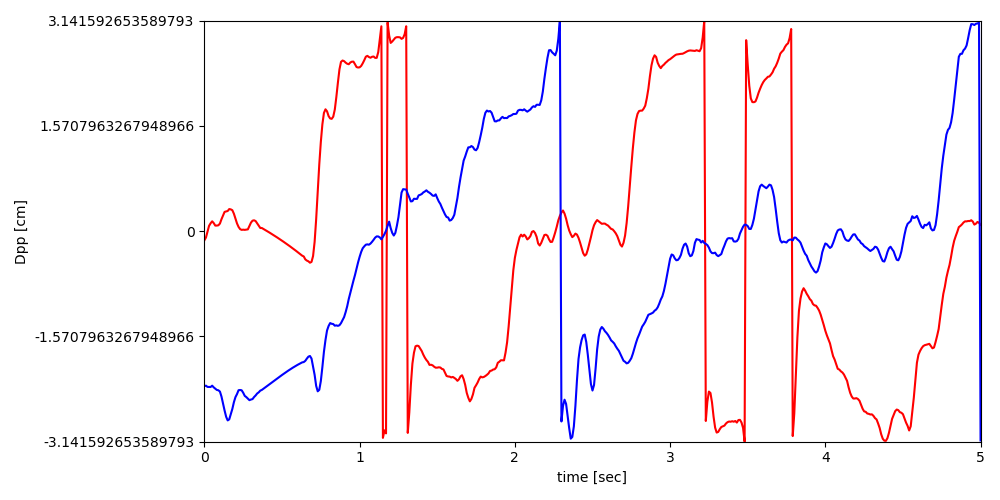

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax = axs
ax.plot(tetW[f0:f0+501], label='thetaW', color='red')
ax.plot(tetL[f0:f0+501], label='thetaL', color='blue')

ax.set_xlim(0,500)
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
ax.set_xlabel('time [sec]')

ax.set_ylim(-np.pi, np.pi)
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_ylabel('Dpp [cm]')

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
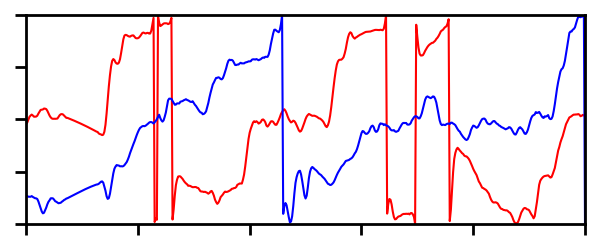

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,2.5))

ax = axs
ax.plot(tetW[f0:f0+501], label='thetaW', color='red')
ax.plot(tetL[f0:f0+501], label='thetaL', color='blue')

ax.set_xlim(0,500)
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels([])
ax.set_xlabel('')

ax.set_ylim(-np.pi, np.pi)
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels([])
ax.set_ylabel('')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#ax.legend(fontsize=16, frameon=False, labelspacing=1) #
fig.tight_layout()

#fig.savefig('/home/liam/temp/image_transfer/thetas_plot.png', dpi=300, transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
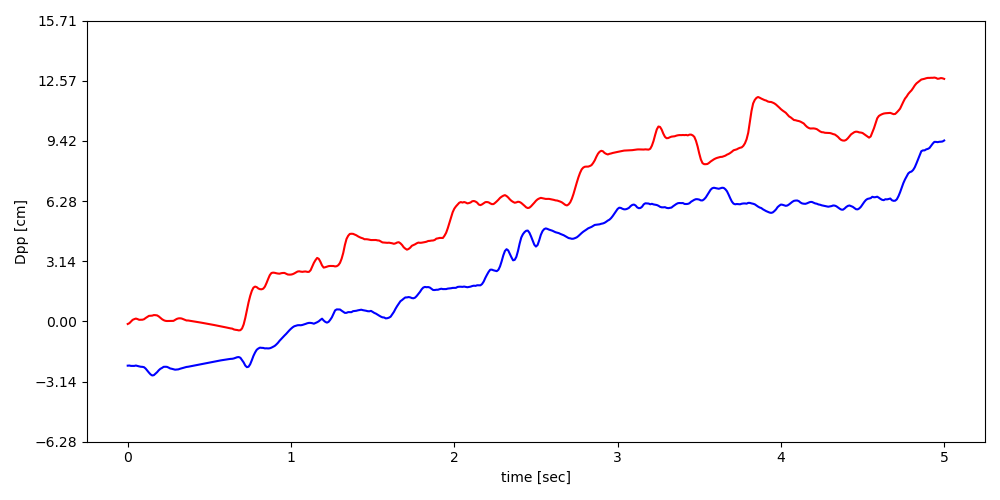

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

tetW_unwrapped = np.unwrap(tetW[f0:f0+501])
tetL_unwrapped = np.unwrap(tetL[f0:f0+501])

ax = axs
ax.plot(tetW_unwrapped, label='thetaW', color='red')
ax.plot(tetL_unwrapped, label='thetaL', color='blue')

#ax.set_xlim(0,500)
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels(['0', '1', '2', '3', '4', '5'])
ax.set_xlabel('time [sec]')

ax.set_ylim(-2*np.pi, np.pi*5)
yticks = [np.pi*i for i in range(-2,6)]
ax.set_yticks(yticks)
ax.set_ylabel('Dpp [cm]')

fig.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
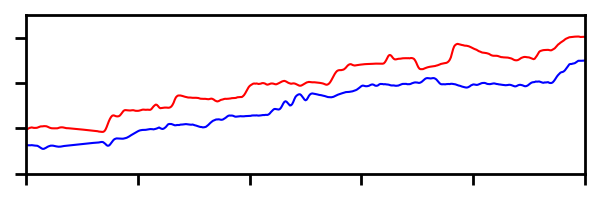

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,2))

tetW_unwrapped = np.unwrap(tetW[f0:f0+501])
tetL_unwrapped = np.unwrap(tetL[f0:f0+501])

ax = axs
ax.plot(tetW_unwrapped, label='thetaW', color='red')
ax.plot(tetL_unwrapped, label='thetaL', color='blue')

ax.set_xlim(0,500)
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_xticklabels([])
ax.set_xlabel('')

ax.set_ylim(-2*np.pi, np.pi*5)
yticks = [np.pi*i for i in range(-2,6,2)]
ax.set_yticks(yticks)
ax.set_yticklabels([])
ax.set_ylabel('')


# ax.set_ylim(-np.pi, np.pi)
# ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
# ax.set_yticklabels([])
# ax.set_ylabel('')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
#ax.legend(fontsize=16, frameon=False, labelspacing=1) #
fig.tight_layout()

fig.savefig('/home/liam/temp/image_transfer/fig1_C_bottom.png', dpi=300, transparent=True)